In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sewar

image1 = cv2.imread('data/drivingLicenseTemplate.png', cv2.IMREAD_COLOR)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread("data/drivingLicense3.jpg", cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_AREA)

image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# cv2.imshow("image1", image1_gray)
# cv2.waitKey(0)
# cv2.imshow("image2", image2_gray)
# cv2.waitKey(0)

print(image1_gray.shape, image2_gray.shape)

#ssim_score = metrics.structural_similarity(image1_gray, image2_gray, full=True)
#print(f"SSIM: {round(ssim_score[0], 2)}")
rase = sewar.rase(image1_gray, image2_gray)
ssim_score = sewar.ssim(image1_gray, image2_gray)

print(f"SSIM: {ssim_score}")
print(f"RASE: {-rase}")

(544, 850) (544, 850)
SSIM: (0.22013614663729894, 0.25633719331951293)
RASE: -2237.5634911187644


In [3]:
from cv2 import Mat
from numpy import ndarray
from numpy import dtype
from numpy import generic
from typing import List, Sequence, Union, Any

def reorder(points: Union[Mat, ndarray[Any, dtype[generic]], ndarray]):
    points = points.reshape((4, 2))
    points_new = np.zeros((4, 1, 2), dtype=np.int32)
    add = points.sum(1)

    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]

    diff = np.diff(points, axis=1)

    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def biggest_contour(contours: Sequence[Union[Mat, ndarray[Any, dtype[generic]], ndarray]]):
    biggest = None
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:
            epsilon = 0.02
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

height, width = image1.shape[:2]
image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_AREA)
threshold_step: int = 5

#cv2.namedWindow("Trackbar")
#cv2.createTrackbar("Threshold1", "Trackbar", 0, 255, lambda: None)
#cv2.createTrackbar("Threshold2", "Trackbar", 0, 255, lambda: None)
#for threshold in range(0, 120, threshold_step):
#thresh1 = cv2.getTrackbarPos("Threshold1", "Trackbar")
#thresh2 = cv2.getTrackbarPos("Threshold2", "Trackbar")
img_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
cv2.imwrite(f"temp/gray.jpg", img_gray)
img_blur = cv2.GaussianBlur(img_gray, (11, 11), 0)
cv2.imwrite(f"temp/blur.jpg", img_blur)

img_threshold = cv2.Canny(img_blur, thresh1, thresh2, 0)

kernel = np.ones((5, 5))
img_dilate = cv2.dilate(img_threshold, kernel, iterations=2)
img_erode = cv2.erode(img_dilate, kernel, iterations=2)

contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

biggest, max_area = biggest_contour(contours)

cv2.imwrite(f"temp/image2.jpg", image2)
cv2.waitKey(300)


-1

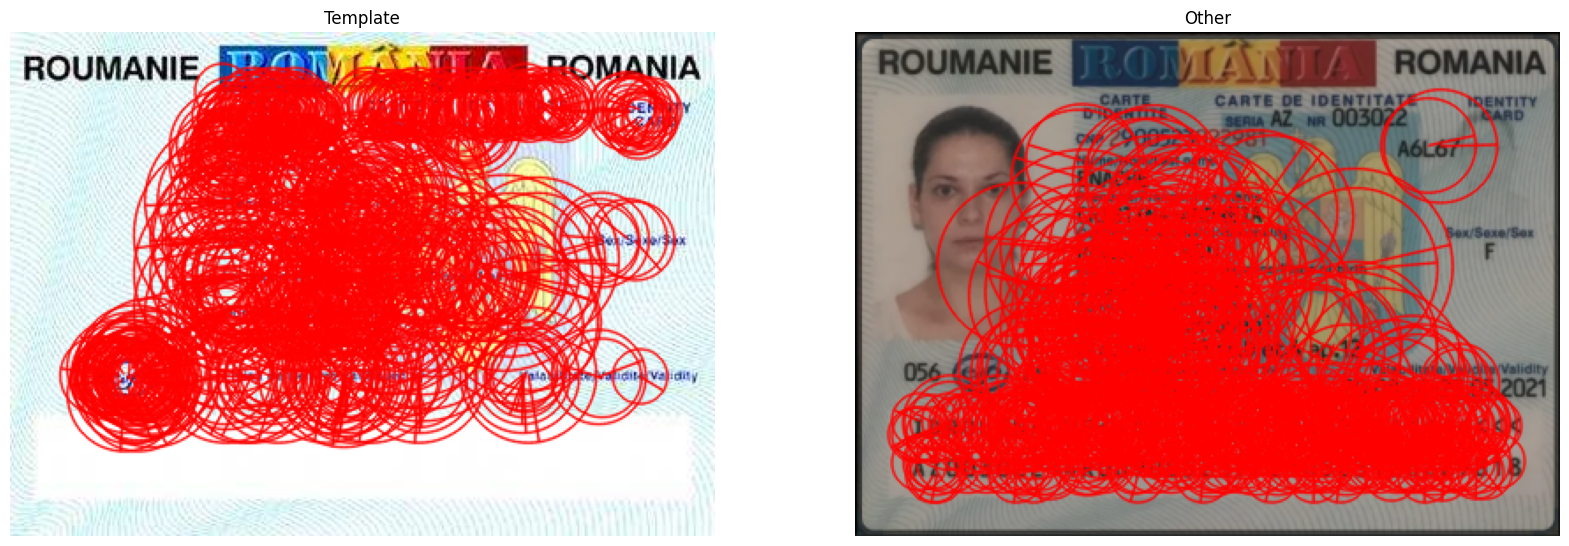

In [136]:
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)

keypoints1, descriptors1 = orb.detectAndCompute(image1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2_gray, None)

im1_display = cv2.drawKeypoints(image1, keypoints1, outImage=np.array([]), color=(255, 0, 0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(image2, keypoints2, outImage=np.array([]), color=(255, 0, 0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.axis('off')
plt.title("Template")
plt.imshow(im1_display)

plt.subplot(122)
plt.axis('off')
plt.title("Other")
plt.imshow(im2_display)

<class 'list'>


Text(0.5, 1.0, 'Template')

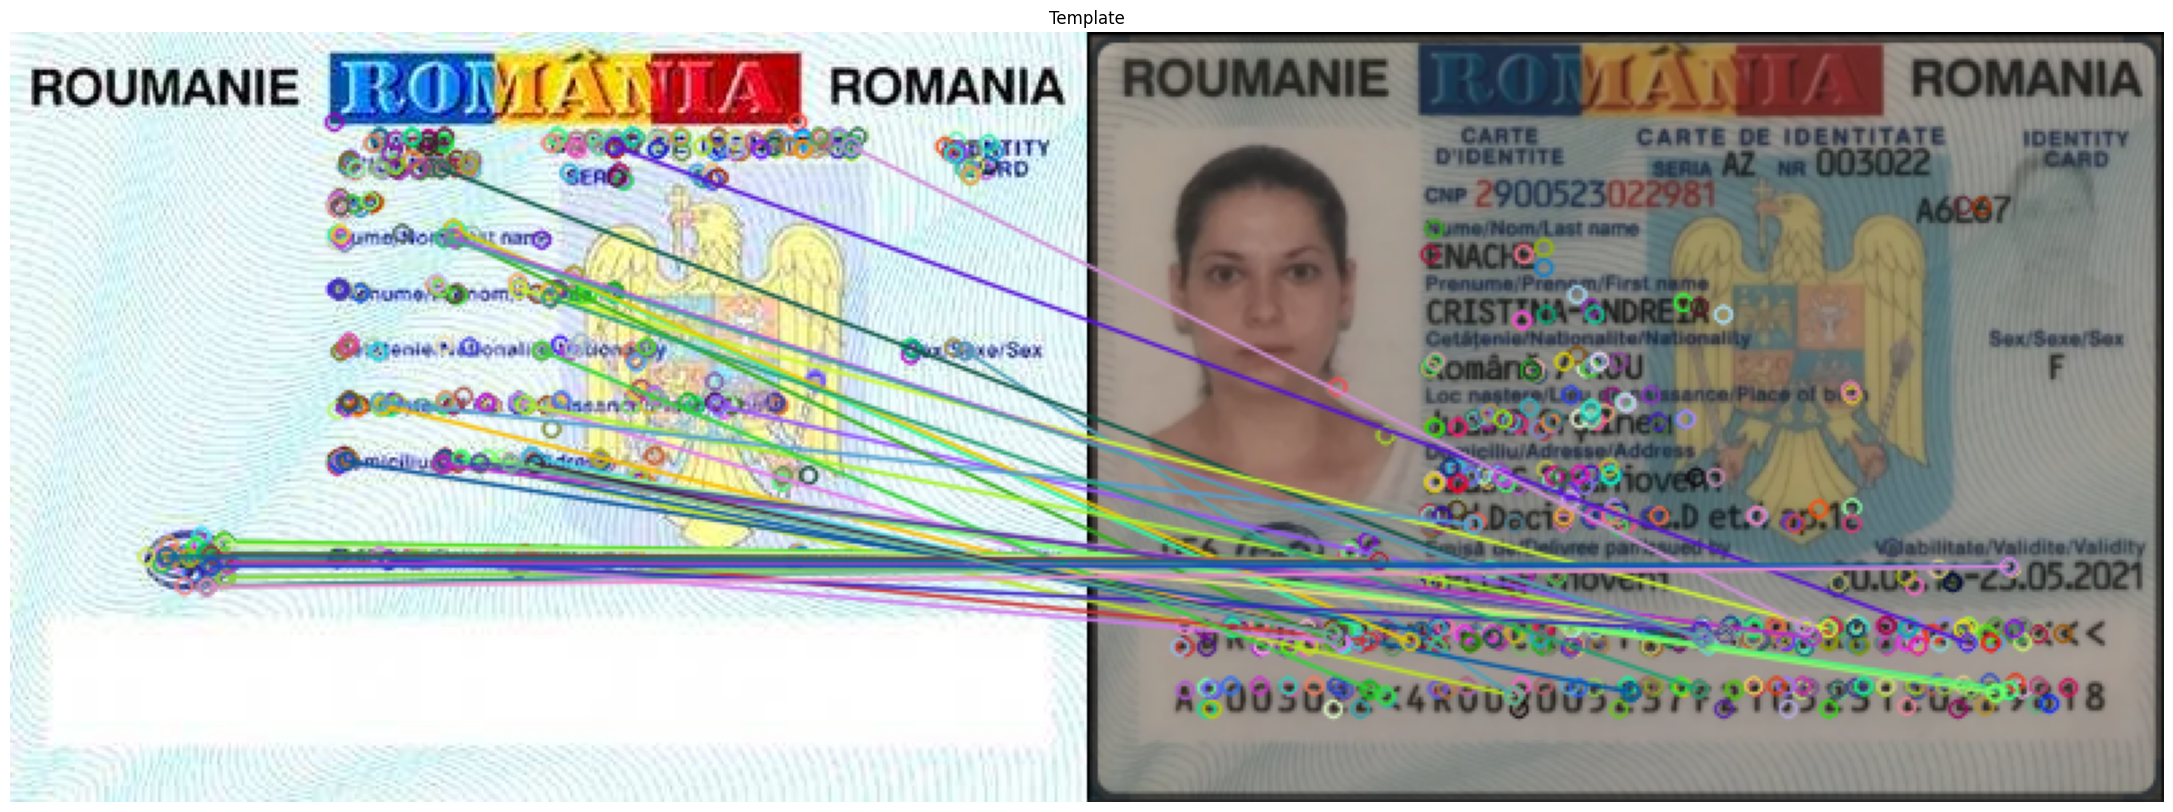

In [137]:
from typing import List

#match features
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches: List[cv2.DMatch] = list(matcher.match(descriptors1, descriptors2, None))

print(type(matches))
#sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

#remove not so good matches
numberOfGoodMatches = int(len(matches) * 0.1)
matches = matches[:numberOfGoodMatches]

im_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)
plt.figure(figsize=(40, 10))
plt.imshow(im_matches)
plt.axis('off')
plt.title("Template")


4. Find homography

In [138]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

5. Warp image

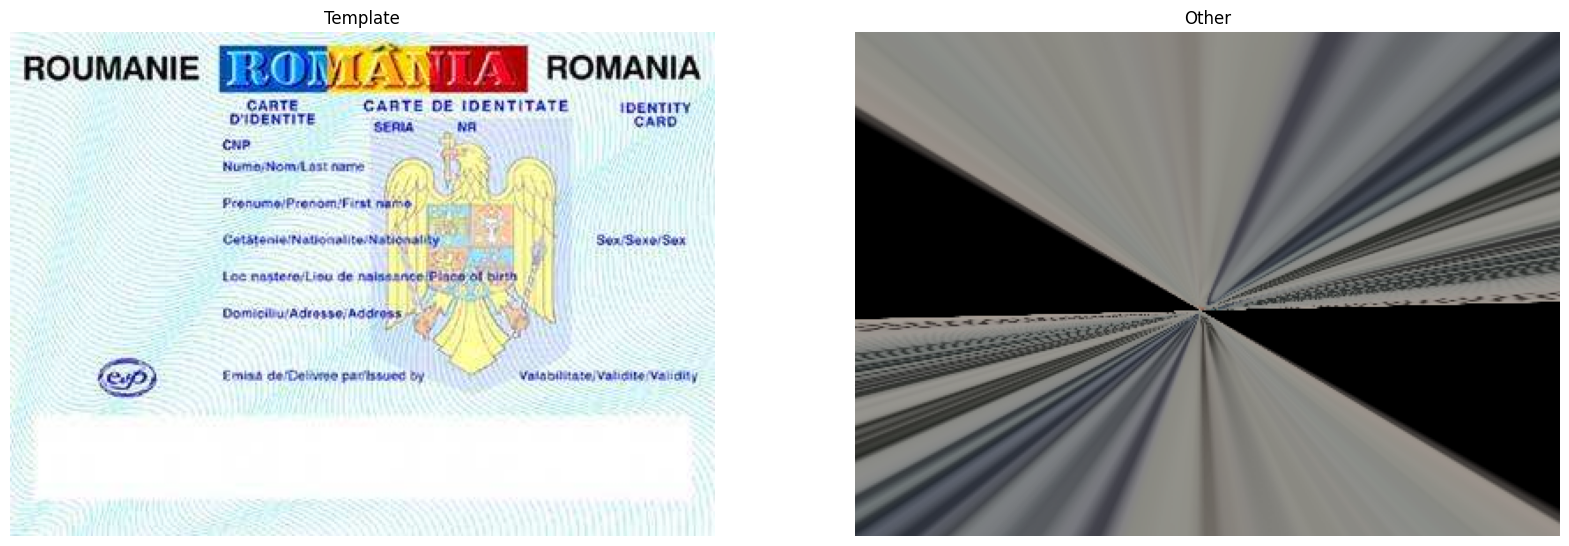

In [139]:
height, width, channels = image1.shape
im1_reg = cv2.warpPerspective(image2, h, (width, height))

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.axis('off')
plt.title("Template")
plt.imshow(image1)

plt.subplot(122)
plt.axis('off')
plt.title("Other")
plt.imshow(im1_reg)